In [1]:
import sys
import pandas as pd
import numpy as np

# Define a random seed for reproducibility
seed = 0
np.random.seed(seed)

import sklearn
import xgboost
import keras
import tensorflow as tf

import os
import pickle


print('Python: {}'.format(sys.version))
print('Pandas: {}'.format(pd.__version__))
print('Numpy: {}'.format(np.__version__))
print('Sklearn: {}'.format(sklearn.__version__))
print('XGBoost: {}'.format(xgboost.__version__))
print('Keras: {}'.format(keras.__version__))

Using TensorFlow backend.


Python: 3.6.10 |Anaconda, Inc.| (default, May  7 2020, 19:46:08) [MSC v.1916 64 bit (AMD64)]
Pandas: 1.0.3
Numpy: 1.18.1
Sklearn: 0.22.1
XGBoost: 1.1.1
Keras: 2.3.1


In [2]:
def load_train_and_test(path):

    """Loads training features, training labels, testing features, and testing features
    Parameters:
        path (str) -- a single directory path containing all four datasets
    """

    train_features = pd.read_csv(path + 'train_features.csv', index_col=0)
    train_labels = pd.read_csv(path + 'train_labels.csv', index_col=0)
    test_features = pd.read_csv(path + 'test_features.csv', index_col=0)
    test_labels = pd.read_csv(path + 'test_labels.csv', index_col=0)

    return train_features, train_labels.values.ravel(), test_features, test_labels.values.ravel()

X_train, Y_train, X_test, Y_test = load_train_and_test('../data/split/')

In [3]:
from sklearn.metrics import roc_auc_score

def permutation_importance(X, y, model): 
    
    """ Add random permutations to each variable in training data to assess variable importance """
    
    perm = {}
    y_true = model.predict_proba(X)[:,1]
    baseline= roc_auc_score(y, y_true)
    
    print('Baseline ROC AUC score: {}'.format(baseline))

    for cols in X.columns:
        new_df = X.copy()
        values = new_df.loc[:,cols]
        new_df.loc[:,cols] = np.random.permutation(values)
        y_true = model.predict_proba(new_df)[:,1]
        perm[cols] = roc_auc_score(y, y_true) - baseline
        
    return perm

In [4]:
# load all optimized models from the models folder

dirName = '../models/'

fileList = list()
dirList = list()

for (dirpath, dirnames, filenames) in os. walk(dirName):
    for file in filenames:
        if '.sav' in file:
            fileList.append(os.path. join(dirpath, file))

modelList = list()

for file in fileList:
    model = pickle.load(open(file, 'rb'))
    modelList.append(model)

In [5]:
# run permutation analysis for each variable and each model

permutations = []

for i,model in enumerate(modelList):
    perms = permutation_importance(X_train.copy(), Y_train.copy(), model)
    permutations.append(perms)
    
scores = pd.DataFrame(permutations, index = [file.split('/')[-1].rstrip('.sav') for file in fileList])
scores

Baseline ROC AUC score: 0.6735426211379179
Baseline ROC AUC score: 0.8741903450766211
Baseline ROC AUC score: 0.6183393892888578
Baseline ROC AUC score: 0.6877948046672234
Baseline ROC AUC score: 0.932677334175901
Baseline ROC AUC score: 0.7910808187952787
Baseline ROC AUC score: 0.8467072152384392
Baseline ROC AUC score: 0.8483462727662551


,SEX_male,RETURNOR_Yes,AGE,BMI,OPTIME,PRSODM,PRBUN,PRCREAT,PRPLATE,PRPTT,PRPT
AdaBoost,0.000000,-0.076900,0.000000,0.000000,0.000000,0.000000,-0.044892,0.000000,0.000000,0.000000,-0.102572
DecisionTree,0.000000,-0.103351,-0.009448,-0.022811,-0.020490,-0.102646,-0.060806,-0.078864,-0.063413,-0.023559,-0.095195
GradientBoosting,0.000000,-0.079324,0.000000,0.000000,0.000000,0.000000,-0.027229,0.000000,0.000000,0.000000,0.000000
LogisticRegression,-0.000570,-0.077033,-0.006906,-0.012481,-0.011409,0.001884,-0.077450,0.003950,-0.005433,-0.030998,0.003436
MLP,-0.161502,-0.069004,-0.155657,-0.173554,-0.151194,-0.153572,-0.113470,-0.130256,-0.074150,-0.121008,-0.079335
RandomForest,0.000000,-0.066699,-0.034166,-0.012980,-0.000576,-0.026239,-0.040999,-0.010949,-0.006847,-0.021285,-0.069049
SVC,-0.019392,-0.048325,-0.042367,-0.051965,-0.041419,-0.086241,-0.063469,-0.037526,-0.034084,-0.038079,-0.019770
XGBoost,0.000000,-0.055113,-0.004407,-0.013744,-0.023472,-0.022171,-0.028880,-0.023559,-0.019514,-0.017821,-0.088097


In [6]:
# print total permutation values for all optimized models

# Note - more negative values mean the algorithm was impacted significantly by permutations of this column (ie, this column is an important variable)
# Note - positive values may indicate the algorithm's performance is decreased by inclusion of this variable. 

totals = scores.mean(axis=0)
totals.sort_values()

RETURNOR_Yes   -0.071969
PRBUN          -0.057149
PRPT           -0.056323
PRSODM         -0.048623
BMI            -0.035942
PRCREAT        -0.034650
AGE            -0.031619
PRPTT          -0.031594
OPTIME         -0.031070
PRPLATE        -0.025430
SEX_male       -0.022683
dtype: float64

In [7]:
# Print top 10 most important variables
totals.sort_values()[:10]

RETURNOR_Yes   -0.071969
PRBUN          -0.057149
PRPT           -0.056323
PRSODM         -0.048623
BMI            -0.035942
PRCREAT        -0.034650
AGE            -0.031619
PRPTT          -0.031594
OPTIME         -0.031070
PRPLATE        -0.025430
dtype: float64

In [8]:
data = totals.sort_values(ascending=False) * -1

In [9]:
import matplotlib.pyplot as plt

def plot_bar_score(scores, tree=True, offset=0.002, save=False):
    
    pos = np.arange(len(scores))

    plt.figure(figsize=(10,14))
    rects = plt.barh(pos, scores,
                     align='center',
                     height = 0.9,
                     tick_label = scores.keys(),
                     alpha = 0.5
                    )
    
    for rect in rects:
        plt.text(rect.get_width() + offset, rect.get_y(), round(rect.get_width(),3), ha='center', va='bottom')
        
    if tree:
        plt.title("Average Impurity-Based Feature Importance for Tree Algorithms")
    else:
        plt.title("Feature Importance: Average Decrease in AUC Score in Permutation Analysis")
        
    plt.xlim(np.min(scores) - offset, np.max(scores) + offset*2)
    
    #plt.tight_layout()
    
    if save:
        plt.savefig('../reports/figures/{}_bar_graph.png'.format('permutation'))
    plt.show

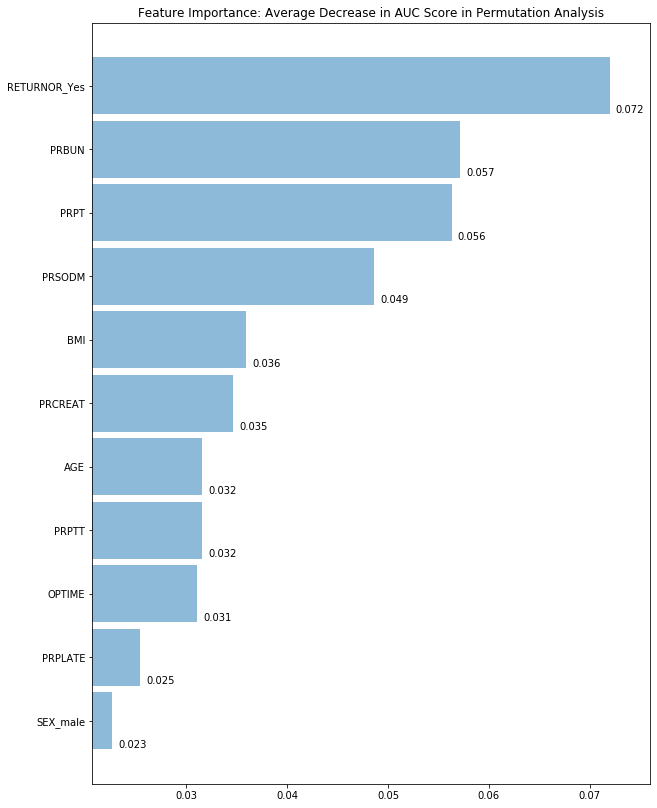

In [10]:
plot_bar_score(data, tree=False, save=True)

In [11]:
# using impurity-based feature importance from tree based approachs
importance = pd.DataFrame(columns=X_train.columns)
stds = pd.DataFrame(columns=X_train.columns)

i=0
for model in modelList:
     
    if hasattr(model, 'feature_importances_'):
        importance.loc[i] = model.feature_importances_
        i += 1

In [12]:
totals = importance.mean(axis=0).sort_values(ascending=True)

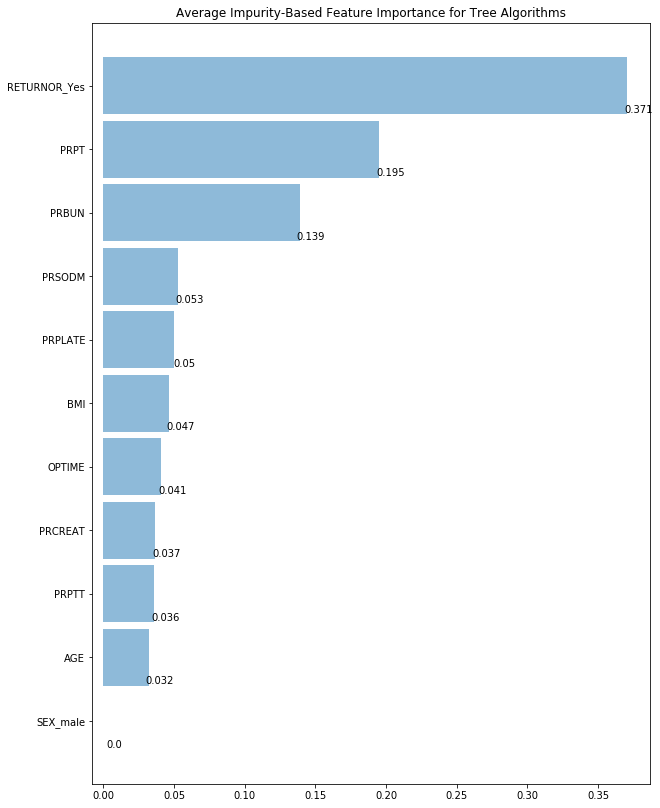

In [13]:
plot_bar_score(totals, offset=0.008, save=True)